In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import uproot
import awkward as ak

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../combine")

import utilsPlots_beforeCombine
import utilsPlots_afterCombine

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return round(lum_)

years = ["2018", "2017", "2016", "2016APV"]
channels = ["ele", "mu"]
get_lumi(years ,channels)

138

# Hist

In [5]:
! ls ../combine/templates/vtest

ls: ../combine/templates/vtest: No such file or directory


In [6]:
# get lumi
import pickle as pkl

version = "v17"
year = "Run2"
with open(f"../combine/templates/{version}/hists_templates_{year}.pkl", "rb") as f:
    h = pkl.load(f)

In [7]:
h

Hist(
  StrCategory(['Data', 'EWKvjets', 'WH', 'TTbar', 'SingleTop', 'DYJets', 'Diboson', 'ttH', 'WJetsLNu', 'ZH', 'mjj1000toInf', 'VBF', 'ggFpt200to300', 'ggFpt300to450', 'ggFpt450toInf', 'ggF', 'Fake'], growth=True, name='Sample'),
  StrCategory(['nominal', 'trigger_ele_SF_up', 'trigger_ele_SF_down', 'EW_up', 'EW_down', 'weight_pdf_acceptance_up', 'weight_pdf_acceptance_down', 'weight_qcd_scale_up', 'weight_qcd_scale_down', 'weight_btagSFlightCorrelated_up', 'weight_btagSFlightCorrelated_down', 'weight_btagSFbcCorrelated_up', 'weight_btagSFbcCorrelated_down', 'weight_btagSFlight_2016_up', 'weight_btagSFlight_2016_down', 'weight_btagSFbc_2016_up', 'weight_btagSFbc_2016_down', 'weight_btagSFlight_2016APV_up', 'weight_btagSFlight_2016APV_down', 'weight_btagSFbc_2016APV_up', 'weight_btagSFbc_2016APV_down', 'weight_btagSFlight_2017_up', 'weight_btagSFlight_2017_down', 'weight_btagSFbc_2017_up', 'weight_btagSFbc_2017_down', 'weight_btagSFlight_2018_up', 'weight_btagSFlight_2018_down', 'wei

/Users/fmokhtar/miniconda3/envs/coffea-env/lib/python3.9/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


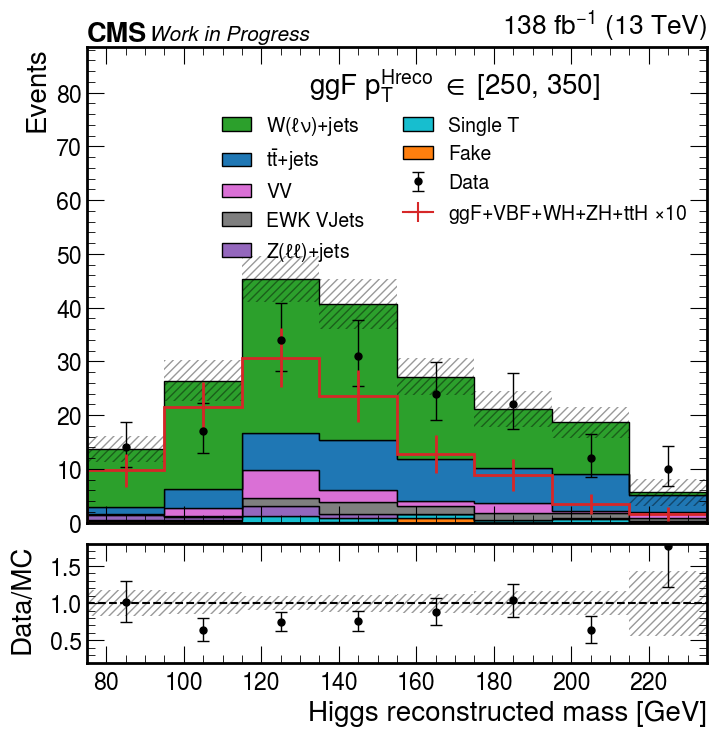

In [9]:
region_dic = {
    "VBF": "VBF category",
    "ggFpt250to350": r"ggF $p_T^{Hreco}$ $\in$ [250, 350]",
    "ggFpt350to500": r"ggF $p_T^{Hreco}$ $\in$ [350, 500]",
    "ggFpt500toInf": r"ggF $p_T^{Hreco}$ $\in$ [500, Inf]",

    "TopCR": "Top control region",
    "WJetsCR": "WJets control region",   
}

# region = "VBF"
region = "ggFpt250to350"
# region = "ggFpt350to500"
# region = "ggFpt500toInf"
# region = "WJetsCR"
# region = "TopCR"

plt.rcParams.update({"font.size": 20})
add_data = True

# if region.startswith("SR"):
add_soverb=True
blind_region=[100,160]
if "VBF" in region:
    mult=5
else:
    mult=10
# else:
#     add_soverb=True
#     blind_region=None
#     blind_region=[90,160]
#     mult=1

if "CR" in region:
    blind_region = False
    mult=1

years = ["2018", "2017", "2016", "2016APV"]
channels = ["ele", "mu"]

samples = list(h.axes["Sample"])
if "ggFpt200to300" in samples:
    samples.remove("ggFpt200to300")
if "ggFpt300to450" in samples:
    samples.remove("ggFpt300to450")
if "ggFpt450toInf" in samples:
    samples.remove("ggFpt450toInf")
if "mjj1000toInf" in samples:
    samples.remove("mjj1000toInf")
    
utilsPlots_beforeCombine.plot_hists(h[{"Sample": samples, "Systematic": "nominal", "Region": region}], years, channels,
            add_data=add_data,
            logy=False,
            add_soverb=add_soverb,
            only_sig=False,
            mult=mult,
            outpath=f"/Users/fmokhtar/Desktop/AN_2024/combine/{version}/",
           save_as=region,
           text_=region_dic[region],
            blind_region=False,
#            remove_samples=["WH", "ZH", "ttH"],
          )

# Systematics

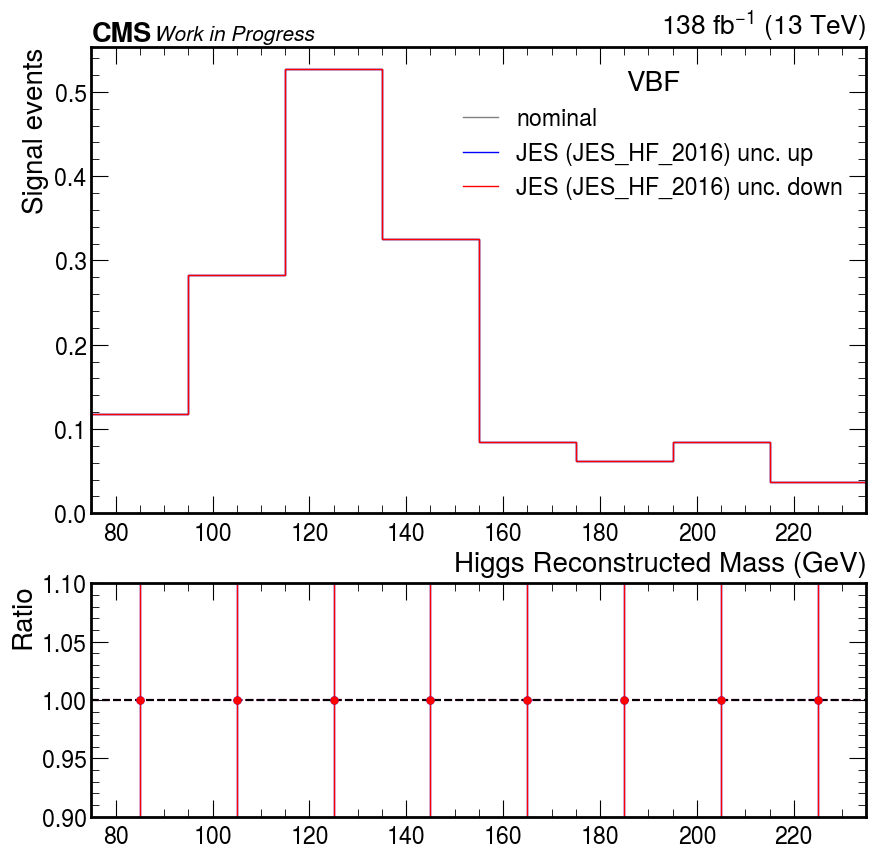

In [30]:
from matplotlib import gridspec
color_dict = {
    "Nominal": "grey",
    "Up": "blue",
    "Down": "red",
}

label_dict = {
    "nominal": "Nominal",
    "up": "Up",
    "down": "Down",    
}


CMS_PARAMS_LABEL = "CMS_HWW_boosted"
syst_dict = {
    "weight_qcd_scale": "QCDScaleacc unc.",
    "weight_pdf_acceptance": "PDFacc unc.",
    "weight_btagSFbcCorrelated": "btagSFbcCorrelated unc.",
    "weight_btagSFlightCorrelated": "btagSFlightCorrelated unc.",
    "weight_pileup_2016APV": "PU unc. 2016APV",
    "weight_pileup_2016": "PU unc. 2016",
    "weight_pileup_2017": "PU unc. 2017",
    "weight_pileup_2018": "PU unc. 2018",
    "weight_pileup_id": "PU ID unc.",
    "UES": "Unclustered energy unc.",
    "weight_L1Prefiring_2016APV": "L1 ecal prefiring (2016APV)",
    "weight_L1Prefiring_2016": "L1 ecal prefiring (2016)",
    "weight_L1Prefiring_2017": "L1 ecal prefiring (2017)",
    "weight_PSFSR": "PS FSR",
    "weight_mu_id": f"{CMS_PARAMS_LABEL}_mu_identification",
    "weight_ele_id": f"{CMS_PARAMS_LABEL}_ele_identification",
    "weight_ele_reco": f"{CMS_PARAMS_LABEL}_ele_reconstruction",
    
    "trigger_ele_SF": "e trigger SF unc.",
    "weight_pileup_2018": "PU (2018) unc.",
    
    "JMR_2018": "JMR (2018) unc.",
    "JMR_2017": "JMR (2017) unc.",
    "JMR_2016": "JMR (2016) unc.",
    "JMR_2016APV": "JMR (2016APV) unc.",
    
    "JMS_2018": "JMS (2018) unc.", 
    "JMS_2017": "JMS (2017) unc.", 
    "JMS_2016": "JMS (2016) unc.", 
    "JMS_2016APV": "JMS (2016APV) unc.",     
    
    "JES_FlavorQCD": "JES (FlavorQCD) unc.",
    "JES_RelativeBal": "JES (JES_RelativeBal) unc.",
    "JES_HF": "JES (JES_HF) unc.",    
    "JES_HF_2016": "JES (JES_HF_2016) unc.",        
}

years = ["2018", "2017", "2016", "2016APV"]
channels = ["ele", "mu"]

bins = list(range(75, 255, 20))#np.linspace(50, 200, 20)  # 40 bins from 0 to 200
    
    
def shape_to_num(var, nom, clip=1.5):
    """
    Estimates the normalized rate from a shape systematic by integrating and dividing by the nominal integrated value.
    """
    nom_rate = np.sum(nom)
    var_rate = np.sum(var)

    if var_rate == nom_rate:  # in cases when both are zero
        return 1

    if abs(var_rate / nom_rate) > clip:
        var_rate = clip * nom_rate

    if var_rate < 0:
        var_rate = 0

    return var_rate / nom_rate


ylim_dict = {
    "WJetsCR": (0.8,1.2),
    "TopCR": (0.2,1.8),    
    "VBF": (-2,4),
    "ggFpt250to350": (0.5,1.5),
    "ggFpt350to500": (0.5,1.5),
    "ggFpt500toInf": (0.5,1.5),
    "test": (0.5,1.5),    
}

lab_region = {
    "ggFpt250to350": "SR: ggFpt250to350",
    "ggFpt350to500": "SR: ggFpt350to500",
    "VBF": "VBF",
}


for region in [
#     "WJetsCR",
    "VBF",
#     "ggFpt250to350",
#     "ggFpt350to500",
#     "ggFpt500toInf",
#     "TopCR"
]:

    for systematic in [
#         "weight_PSFSR",
#         "weight_pileup_2016APV",
#         "weight_pileup_2016",
#         "weight_pileup_2017",
#         "weight_pileup_2018",
#          "JES_FlavorQCD",
#          "JES_RelativeBal",
#          "JES_HF",
#          "JES_BBEC1",
#          "JES_EC2",
#          "JES_Absolute",
        "JES_HF_2016",
#         "UES",
#         "JMS_2018",
#         "JMS_2017",
#         "JMS_2016",
#         "JMS_2016APV",
#         "JMR_2018",
#         "JMR_2017",
#         "JMR_2016",
#         "JMR_2016APV",
#         "trigger_ele_SF",
#         "weight_pileup_2017",
#         "UES",
#         "weight_btagSFbcCorrelated",
    ]:

        max_ = 0
        min_ = 0     
        for sample in [
#             "TTbar",
#             "SingleTop",
#             "WJetsLNu",
            "ggF",
#             "VBF",
    #         "WH",
    #         "ZH",
    #         "EWKvjets",
    #         "ttH",
        ]:

            fig = plt.figure(figsize=(10, 10))
            gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

            ax = plt.subplot(gs[0])
            rax = plt.subplot(gs[1], sharex=ax)

            sum_envelope = {}
            for variation in ["nominal", "up", "down"]:

                syst = variation if variation == "nominal" else f"{systematic}_{variation}"
                lab = "nominal" if variation == "nominal" else f"{syst_dict[systematic]} {variation}"

                nominal = h[{"Sample": sample, "Region": region, "Systematic": f"nominal"}]
                syst_up = h[{"Sample": sample, "Region": region, "Systematic": f"{systematic}_up"}]
                syst_do = h[{"Sample": sample, "Region": region, "Systematic": f"{systematic}_down"}]

                # smoothing
                if (systematic == "weight_pileup_2018"):
                    max_variation = np.maximum(abs(nominal.values()-syst_up.values()), abs(nominal.values()-syst_do.values()))

                    syst_up = nominal.values() + max_variation
                    syst_do = nominal.values() - max_variation

                if variation == "nominal":
                    X = nominal.values()
                elif variation == "up":
                    X = syst_up.values()
                else:
                    X = syst_do.values()

                hep.histplot(
                    X,
                    bins,
                    ax=ax,
                    linewidth=1,
                    histtype="step",
                    label=lab,
                    flow="none",
                    color=color_dict[label_dict[variation]]
                )                    
                ax.set_xlabel(r"Higgs reconstructed mass [GeV]")
                
                if variation == "up":
                    ratio_up = syst_up.values()/nominal.values()
                    hep.histplot(
                        ratio_up,
                        bins = bins,
                        ax=rax,
                        linewidth=1,
                        histtype="errorbar",
                        yerr=np.sqrt( syst_up.variances() / (syst_up.values() ** 2) + nominal.variances()  / (nominal.values() ** 2)) * (syst_up.values()/nominal.values()),
#                         yerr=(syst_up.variances()/nominal) * np.sqrt( (1/syst_up.variances()) + (1/nominal) ),
                        label="up",
                        flow="none",
                        color=color_dict[label_dict[variation]]
                    )
                    rax.axhline(shape_to_num(syst_up.values(), nominal.values(), clip=1.5), ls="--", color=color_dict[label_dict[variation]])
                if variation == "down":                    
                    ratio_down = syst_do.values()/nominal.values()

                    hep.histplot(
                        ratio_down,
                        bins = bins,
                        ax=rax,
                        linewidth=1,
                        histtype="errorbar",
                        yerr=np.sqrt( syst_do.variances() / (syst_do.values() ** 2) + nominal.variances()  / (nominal.values() ** 2)) * (syst_do.values()/nominal.values()),
#                         yerr=(syst_do.values()/nominal) * np.sqrt( (1/syst_do.values()) + (1/nominal) ),
#                         yerr=(syst_do.variances()/nominal) * np.sqrt( (1/syst_do.variances()) + (1/nominal) ),
                        label="down",
                        flow="none",
                        color=color_dict[label_dict[variation]]
                    )   
                    
                    rax.axhline(shape_to_num(syst_do.values(), nominal.values(), clip=1.5), ls="--", color=color_dict[label_dict[variation]])
            
            

    #         ax.legend(title=sample + f" ({syst_dict[systematic]})")
            ax.legend(title=lab_region[region])

#             ax.set_ylabel(f"{sample} Events")
            ax.set_ylabel(f"Signal events")            
            ax.set_xlim(75,235)          
            # ax.set_yscale("log")
            rax.set_ylim(ylim_dict[region])
            rax.set_ylim(0.9,1.1)            
            rax.axhline(1, ls="--", color="k")
            
            rax.set_ylabel("Ratio")
            ax.set_xlabel("")
            ax.set_xlabel("Higgs Reconstructed Mass (GeV)")
    #         print(sample, syst_dict[systematic], f" nominal + {100*abs(1-sum_envelope['up']/sum_envelope['nominal']):.2f}% - {100*abs(1-sum_envelope['down']/sum_envelope['nominal']):.2f}%")

            hep.cms.lumitext(str(get_lumi(years, channels)) + r" fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
            hep.cms.text("Work in Progress", ax=ax, fontsize=15)

            plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/ARC/systematics/{systematic}_{region}_{sample}.pdf")       

# Systematics plots

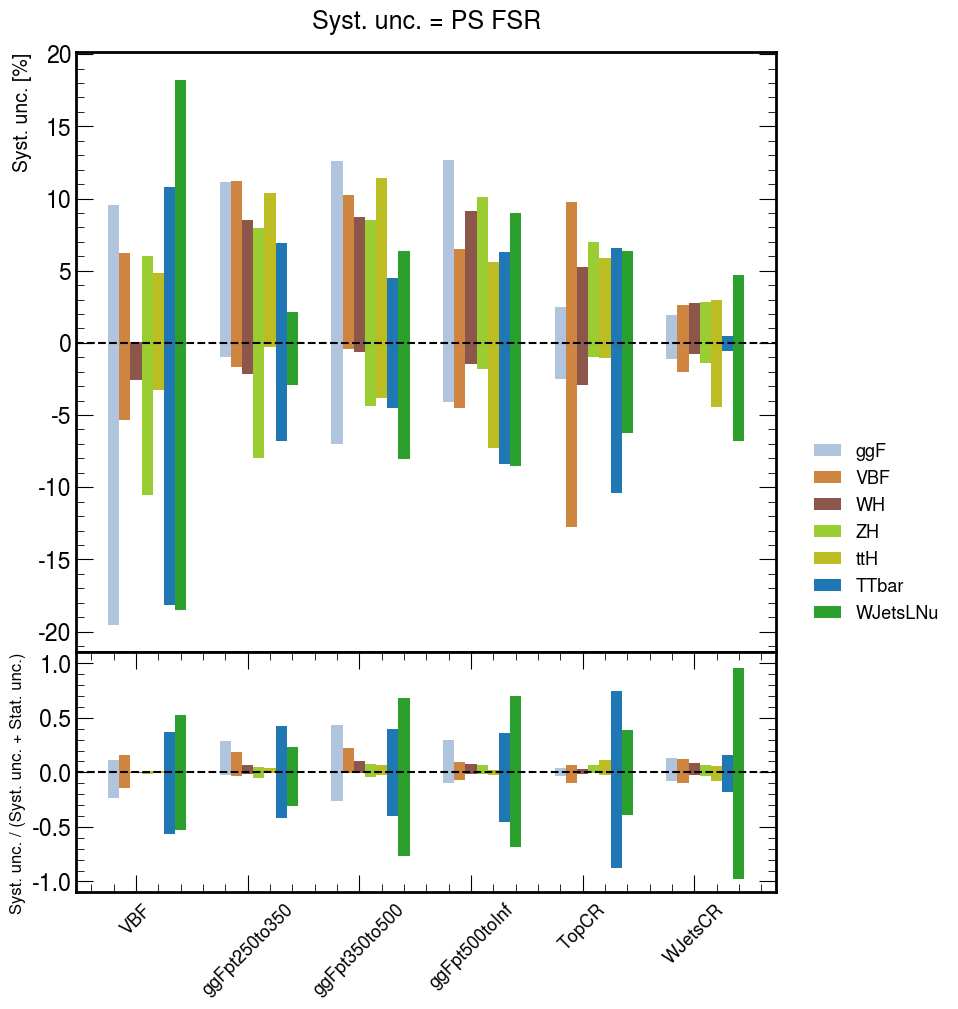

In [121]:
CMS_PARAMS_LABEL = "CMS_HWW_boosted"

color_by_sample = {
    "ggF": "lightsteelblue",
    "VBF": "peru",
    # signal that is background
    "WH": "tab:brown",
    "ZH": "yellowgreen",
    "ttH": "tab:olive",
    # background
    "QCD": "tab:orange",
    "Fake": "tab:orange",
    "WJetsLNu": "tab:green",
    "TTbar": "tab:blue",
    "Diboson": "orchid",
    "SingleTop": "tab:cyan",
    "EWKvjets": "tab:grey",
    "DYJets": "tab:purple",
    "WZQQ": "khaki",
    # "WZQQorDYJets": "khaki",
    # wjets matched and unmatched
    "WJetsLNu_unmatched": "lightgreen",
    "WJetsLNu_matched": "tab:green",
    # ttbar matched and unmatched
    "TTbar_allmatched": "tab:blue",
    "TTbar_unmatched": "lightskyblue",
    "TTbar_LP": "lightskyblue",
}

syst_dict = {
    
    "weight_qcd_scale": "QCD scale acceptance",
    "weight_pdf_acceptance": "PDF acceptance",
    ################## btag    
    "weight_btagSFbcCorrelated": "btagSFbcCorrelated",
    "weight_btagSFlightCorrelated": "btagSFlightCorrelated",

    "weight_btagSFlight_2016APV": "btagSFlight (2016APV)",
    "weight_btagSFlight_2016": "btagSFlight (2016)",
    "weight_btagSFlight_2017": "btagSFlight (2017)",
    "weight_btagSFlight_2018": "btagSFlight (2018)",    

    "weight_btagSFbc_2016APV": "btagSFbc (2016APV)",
    "weight_btagSFbc_2016": "btagSFbc (2016)",
    "weight_btagSFbc_2017": "btagSFbc (2017)",
    "weight_btagSFbc_2018": "btagSFbc (2018)",    

    ################## common
    "weight_PSFSR": "PS FSR",
    "weight_PSISR": "PS ISR",
    "weight_pileup_id": "PU Jet ID",
    "weight_pileup_2016APV": "PU unc. 2016APV",
    "weight_pileup_2016": "PU 2016",
    "weight_pileup_2017": "PU 2017",
    "weight_pileup_2018": "PU 2018",
    "weight_L1Prefiring_2016APV": "L1 ecal prefiring (2016APV)",
    "weight_L1Prefiring_2016": "L1 ecal prefiring (2016)",
    "weight_L1Prefiring_2017": "L1 ecal prefiring (2017)",
    "weight_mu_id_stat": f"{CMS_PARAMS_LABEL}_mu_identification_stat",
    "weight_mu_id_syst": f"{CMS_PARAMS_LABEL}_mu_identification_syst",    
    "weight_ele_id": f"{CMS_PARAMS_LABEL}_ele_identification",
    "weight_ele_reco": f"{CMS_PARAMS_LABEL}_ele_reconstruction",
    "weight_ele_isolation": f"{CMS_PARAMS_LABEL}_ele_isolation",
    "weight_mu_isolation": f"{CMS_PARAMS_LABEL}_mu_isolation",
    "weight_ele_trigger": f"{CMS_PARAMS_LABEL}_ele_trigger",
    "weight_mu_trigger_noniso": f"{CMS_PARAMS_LABEL}_mu_trigger",
    "weight_mu_trigger_iso": f"{CMS_PARAMS_LABEL}_mu_trigger_iso",   
    
    "trigger_ele_SF": f"{CMS_PARAMS_LABEL}_ele_trigger",
    
    ################## JECs corr
    "UES": "Unclustered energy",
    "JES_FlavorQCD": "CMS_scale_j_FlavQCD",
    "JES_RelativeBal": "CMS_scale_j_RelBal",
    "JES_HF": "CMS_scale_j_HF",
    "JES_BBEC1": "CMS_scale_j_BBEC1",
    "JES_EC2": "CMS_scale_j_EC2",
    "JES_Absolute": "CMS_scale_j_Abs",
    
    ################## JECs uncorr
    "JES_BBEC1_2016APV": "CMS_scale_j_BBEC1_2016APV",
    "JES_BBEC1_2016": "CMS_scale_j_BBEC1_2016",
    "JES_BBEC1_2017": "CMS_scale_j_BBEC1_2017",
    "JES_BBEC1_2018": "CMS_scale_j_BBEC1_2018",
    
    "JES_RelativeSample_2016APV": "CMS_scale_j_RelSample_2016APV",
    "JES_RelativeSample_2016": "CMS_scale_j_RelSample_2016",
    "JES_RelativeSample_2017": "CMS_scale_j_RelSample_2017",
    "JES_RelativeSample_2018": "CMS_scale_j_RelSample_2018",
    
    "JES_HF_2016APV": "CMS_scale_j_HF_2016APV",
    "JES_HF_2016": "CMS_scale_j_HF_2016",
    "JES_HF_2017": "CMS_scale_j_HF_2017",
    "JES_HF_2018": "CMS_scale_j_HF_2018",    
    
    "JES_EC2_2016APV": "CMS_scale_j_EC2_2016APV",
    "JES_EC2_2016": "CMS_scale_j_EC2_2016",
    "JES_EC2_2017": "CMS_scale_j_EC2_2017",
    "JES_EC2_2018": "CMS_scale_j_EC2_2018",    
    
    "JES_Absolute_2016APV": "CMS_scale_j_Abs_2016APV",
    "JES_Absolute_2016": "CMS_scale_j_Abs_2016",
    "JES_Absolute_2017": "CMS_scale_j_Abs_2017",
    "JES_Absolute_2018": "CMS_scale_j_Abs_2018",        
    
    "JMS_2016APV": "CMS_jms_2016APV",
    "JMS_2016": "CMS_jms_2016",
    "JMS_2017": "CMS_jms_2017",
    "JMS_2018": "CMS_jms_2018",

    "JMR_2016APV": "CMS_jmr_2016APV",
    "JMR_2016": "CMS_jmr_2016",
    "JMR_2017": "CMS_jmr_2017",
    "JMR_2018": "CMS_jmr_2018",   

    "JER_2016APV": "CMS_res_j_2016APV",
    "JER_2016": "CMS_res_j_2016",
    "JER_2017": "CMS_res_j_2017",
    "JER_2018": "CMS_res_j_2018",   
}


regions = [
#     "Pre-selection",
    "VBF",
    "ggFpt250to350",
    "ggFpt350to500",
    "ggFpt500toInf",    
    "TopCR",
    "WJetsCR",
]
samples = [
    "ggF", 
    "VBF", 
    "WH", 
    "ZH", 
    "ttH",
    "TTbar",
    "WJetsLNu",
]
sigs = [
    "ggF", 
    "VBF", 
    "WH", 
    "ZH", 
    "ttH",
]

for systematic in [
#     "weight_pdf_acceptance", 
    "weight_PSFSR",
#     "weight_PSISR",
#     "weight_qcd_scale",
#     ################# btag
#     "weight_btagSFbcCorrelated", 
#     "weight_btagSFlightCorrelated",
#     "weight_btagSFlight_2016APV",
#     "weight_btagSFlight_2016",
#     "weight_btagSFlight_2017",
#     "weight_btagSFlight_2018",
#     "weight_btagSFbc_2016APV",
#     "weight_btagSFbc_2016",
#     "weight_btagSFbc_2017",
#     "weight_btagSFbc_2018",    
#     ################## common

#     "weight_pileup_id",
#     "weight_pileup_2016APV",
#     "weight_pileup_2016",
#     "weight_pileup_2017",
#     "weight_pileup_2018", 
#     "weight_pileup_id",
#     "weight_L1Prefiring_2016APV",
#     "weight_L1Prefiring_2016",
#     "weight_L1Prefiring_2017",
#     "weight_ele_id",
#     "weight_ele_reco",    
#     "weight_mu_id_syst",
#     "weight_mu_id_stat",
#     "weight_mu_isolation",
#     "trigger_ele_SF",
#     "weight_mu_trigger_noniso",
#     "weight_mu_trigger_iso",    
#     ################# JECs correlated   
#      "UES",
#      "JES_FlavorQCD",
#      "JES_RelativeBal",
#      "JES_HF",
#      "JES_BBEC1",
#      "JES_EC2",
#      "JES_Absolute",

# #     ################# JECs uncorrelated  
#     "JES_BBEC1_2016APV",
#     "JES_BBEC1_2016",
#     "JES_BBEC1_2017",
#     "JES_BBEC1_2018",    
#     "JES_RelativeSample_2016APV",
#     "JES_RelativeSample_2016",
#     "JES_RelativeSample_2017",
#     "JES_RelativeSample_2018",    
#     "JES_EC2_2016APV",
#     "JES_EC2_2016",
#     "JES_EC2_2017",
#     "JES_EC2_2018",    
#     "JES_HF_2016APV",
#     "JES_HF_2016",
#     "JES_HF_2017",
#     "JES_HF_2018",    
#     "JES_Absolute_2016APV",
#     "JES_Absolute_2016",
#     "JES_Absolute_2017",
#     "JES_Absolute_2018",
    
#     "JMS_2016APV",
#     "JMS_2016",
#     "JMS_2017",
#     "JMS_2018",

#     "JMR_2016APV",
#     "JMR_2016",
#     "JMR_2017",
#     "JMR_2018",   

#     "JER_2016APV",
#     "JER_2016",
#     "JER_2017",
#     "JER_2018",
#     "weight_ele_d3K_NLOUp",
]:

    bar_width = 0.1

    # Create a figure with two subplots: larger upper subplot and smaller lower subplot
    fig = plt.figure(figsize=(10, 12))

    # Define two subplots: the first one takes more space, the second one is smaller
    ax1 = fig.add_axes([0.1, 0.4, 0.7, 0.5])  # Main plot (relative syst unc)
    ax2 = fig.add_axes([0.1, 0.2, 0.7, 0.2])  # Smaller plot (rel_sys_unc/total_unc)
    
    for iregion, region in enumerate(regions):

        for i, sample in enumerate(samples):

            # Get the nominal yield and calculate stat uncertainty
            nominal_yield = h[region][{"Sample": sample, "Systematic": "nominal"}].values().sum()
            stat_unc = np.sqrt(nominal_yield)
            rel_stat_unc = stat_unc / nominal_yield

            # First plot (relative syst unc): this is the main plot now
            up_yield = h[region][{"Sample": sample, "Systematic": f"{systematic}_up"}].values().sum()
            rel_sys_unc_up = abs(up_yield/nominal_yield-1)
            bars = ax1.bar(iregion + i * bar_width, 100 * rel_sys_unc_up, bar_width, label=sample, color=color_by_sample[sample])

            down_yield = h[region][{"Sample": sample, "Systematic": f"{systematic}_down"}].values().sum()
            rel_sys_unc_down = abs(down_yield / nominal_yield - 1)
            bars = ax1.bar(iregion + i * bar_width, -100 * rel_sys_unc_down, bar_width, color=color_by_sample[sample])

            # Second plot (rel_sys_unc/total_unc): smaller subplot
            total_unc_up = np.sqrt(rel_stat_unc**2 + rel_sys_unc_up**2)
            total_unc_down = np.sqrt(rel_stat_unc**2 + rel_sys_unc_down**2)
            
            X_up = rel_sys_unc_up / total_unc_up
            bars = ax2.bar(iregion + i * bar_width, X_up, bar_width, label=sample, color=color_by_sample[sample])

            X_down = rel_sys_unc_down / total_unc_down
            bars = ax2.bar(iregion + i * bar_width, -X_down, bar_width, color=color_by_sample[sample])

    # Adjust x-tick labels to match the number of regions for both subplots
    ax1.set_xticks([])
    ax2.set_xticks(np.arange(len(regions)) + bar_width * 2)
    ax2.set_xticklabels(regions, rotation=45, fontsize=13)

    # Single legend outside both plots, centered
    handles, labels = ax1.get_legend_handles_labels()[0][:len(samples)], ax1.get_legend_handles_labels()[1][:len(samples)]
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.82, 0.5), fontsize=13)

    # Set titles and labels
    ax1.set_title(f"Syst. unc. = {syst_dict[systematic]}", pad=17, fontsize=18)
    ax1.set_ylabel(f"Syst. unc. [%]", fontsize=14)

    # Set ylabel for the smaller subplot
    ax2.set_ylabel(f"Syst. unc. / (Syst. unc. + Stat. unc.)", fontsize=12)
    ax1.axhline(y=0, color='black', linestyle='--')
    ax2.axhline(y=0, color='black', linestyle='--')
    
    ax2.set_ylim(-1.1,1.1)

    plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/combine/v13/systematics/{systematic}.pdf")

# Post-fit stacked plots

In [13]:
samples_dict = {
    "data": "Data",
    "data_obs": "Data",    
    
    "ggH_hww": "ggF", 
    
    "ggH_hww_200_300": "ggH_hww_200_300",
    "ggH_hww_300_450": "ggH_hww_300_450",
    "ggH_hww_450_Inf": "ggH_hww_450_Inf",
    "qqH_hww_mjj_1000_Inf": "qqH_hww_mjj_1000_Inf",

    "qqH_hww": "VBF",
    "WH_hww": "WH",
    "ZH_hww": "ZH",
    "ttH_hww": "ttH",
    
    "diboson": "Diboson",
    "ewkvjets": "EWKvjets",
    "singletop": "SingleTop",
    "qcd": "QCD",
    "ttbar": "TTbar",
    "wjets": "WJetsLNu",
    "wzqq": "WZQQ",    
    "zjets": "DYJets",      
    "vjets": "WZQQorDYJets",
    
    "fake": "Fake",
}

region_dict = {
    "SR1": "SR: VBF",
    "SR2": r"SR: ggF $p_T^{Hreco}$ [250, 350]",
    "SR3": r"SR: ggF $p_T^{Hreco}$ [350, 500]",
    "SR4": r"SR: ggF $p_T^{Hreco}$ [500, Inf]",

    "CR1": "Top control region",
    "CR2": "WJets control region",
}

massbinwidth = 20

In [14]:
def build_hist_from_rootfile(f, key="shapes_fit_s", region="SR1"):   
    
    ######################
    nbins = len(list(range(75, 255, massbinwidth)))-1
    samples = [samples_dict[sample[:-2]] for sample in f[key][region].keys() if "total" not in sample]
    
    hf = hist2.Hist(
        hist2.axis.StrCategory(samples, name="Sample", growth=True),    
        hist2.axis.Regular(nbins, 75, 235, name="var", label=r"Higgs reconstructed mass [GeV]"),
    )

    for sample in f[key][region].keys():
        if "total" in sample:
            continue

        smpl = samples_dict[sample[:-2]] # there's an additional ";1" that must be removed

        if "data" in sample:
            X = f[key][region][sample].values()[1]*massbinwidth
        else:
            X = f[key][region][sample].values()*massbinwidth

        hf[{"Sample": smpl}] = X
    
    # mc unc.
    tot_err_mc = f[key][region]["total_background"].errors()*massbinwidth

    # data unc.
    tot_mc = f[key][region]["total_background"].values()*massbinwidth
    tot_data = f[key][region]["data"].values()[1]*massbinwidth

    tot_err_data_high = f[key][region]["data"].errors("high")[1]*massbinwidth
    tot_err_data_low = f[key][region]["data"].errors("low")[1]*massbinwidth
    
    tot_err_data = np.where(
        (tot_data > tot_mc),
        tot_err_data_low,   # if tot_data>tot_mc then lower limit of the unc. on data is what matters
        tot_err_data_high,
    )    
    
    return hf, tot_err_mc, tot_err_data

In [15]:
def build_hist_from_rootfile_yuzhe(f, key="shapes_fit_s", region="SR1"):

    ######################
    nbins = len(list(range(75, 255, massbinwidth)))-1
    samples = [samples_dict[sample[:-2]] for sample in f[f"{region}_postfit"].keys() if "Total" not in sample]
    
    hf = hist2.Hist(
        hist2.axis.StrCategory(samples, name="Sample", growth=True),    
        hist2.axis.Regular(nbins, 75, 235, name="var", label=r"Higgs reconstructed mass [GeV]"),
    )

    for sample in f[f"{region}_postfit"].keys():
        if "Total" in sample:
            continue

        smpl = samples_dict[sample[:-2]] # there's an additional ";1" that must be removed

        X = f[f"{region}_postfit"][sample].values()

        hf[{"Sample": smpl}] = X
    
    # mc unc.
    tot_err_mc = f[f"{region}_postfit"]["TotalBkg"].errors()

    # data unc.
    tot_mc = f[f"{region}_postfit"]["TotalBkg"].values()
    tot_data = f[f"{region}_postfit"]["data_obs"].values()

    tot_err_data_high = f[f"{region}_postfit"]["data_obs"].errors("high")[1:-1]
    tot_err_data_low = f[f"{region}_postfit"]["data_obs"].errors("low")[1:-1]
    
    tot_err_data = np.where(
        (tot_data > tot_mc),
        tot_err_data_low,   # if tot_data>tot_mc then lower limit of the unc. on data is what matters
        tot_err_data_high,
    )    
    
    return hf, tot_err_mc, tot_err_data

In [16]:
years = ["2018", "2017", "2016", "2016APV"]
channels = ["ele", "mu"]

from utilsPlots_afterCombine import plot_hists

plt.rcParams.update({"font.size": 20})

# Asimov

In [17]:
out_dir = "/Users/fmokhtar/Desktop/AN_2024/combine/v15/singlePOI/asimov/"
f = uproot.open(f"{out_dir}/fitDiagnosticsAsimov.root")

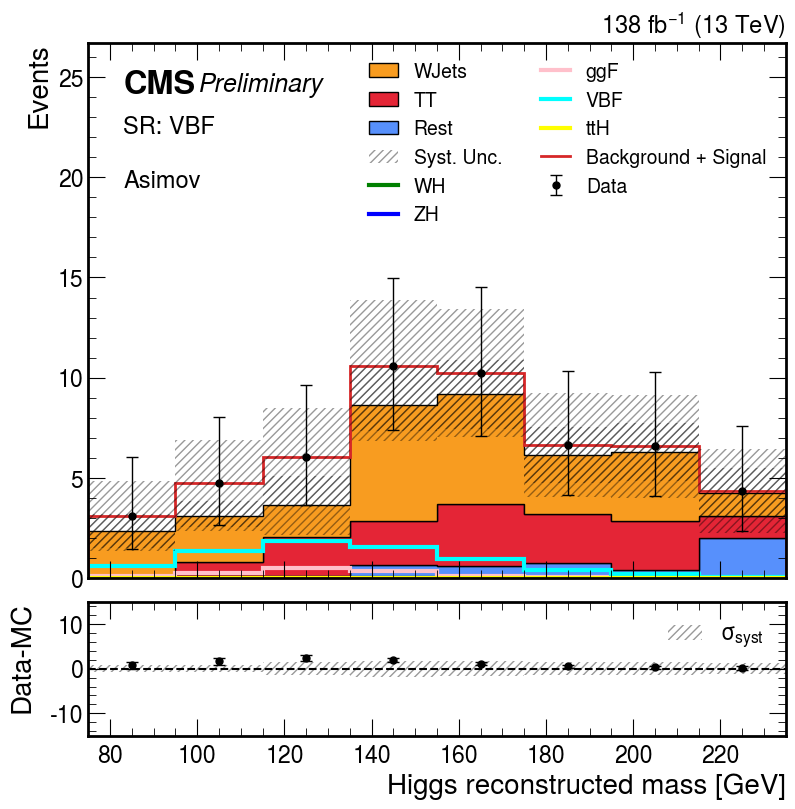

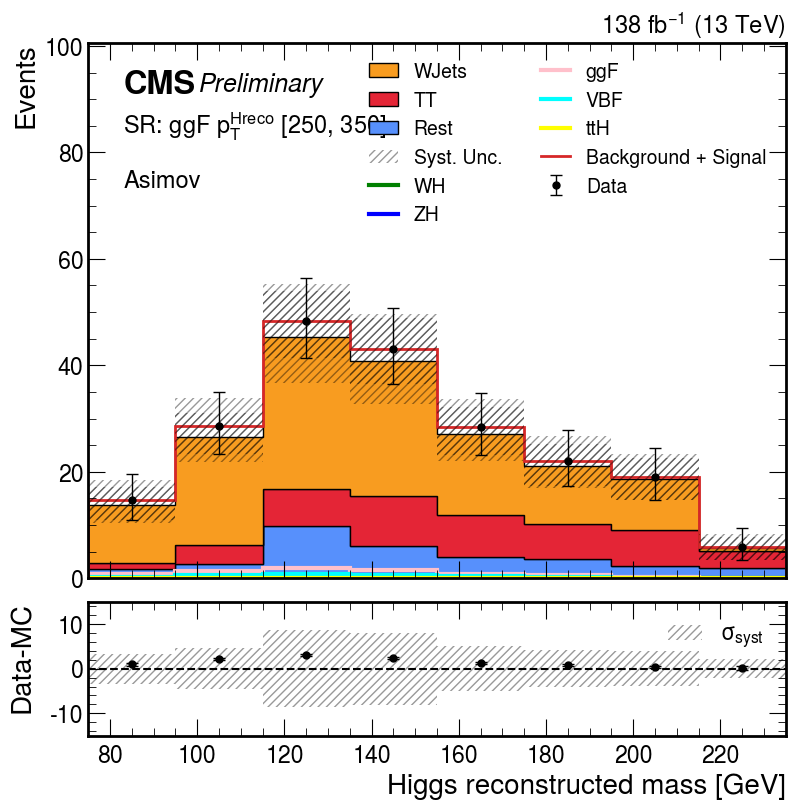

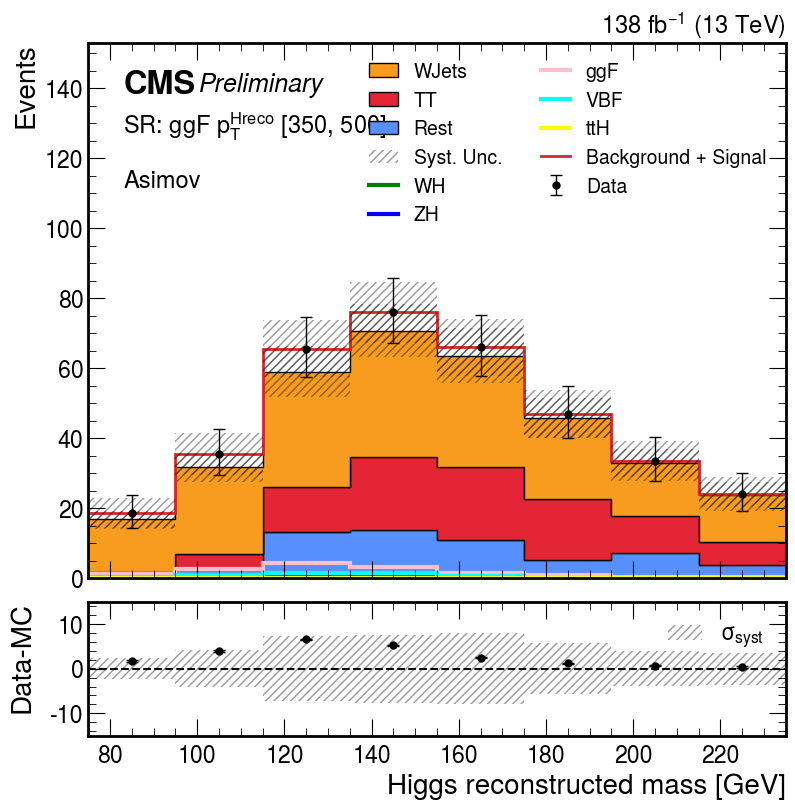

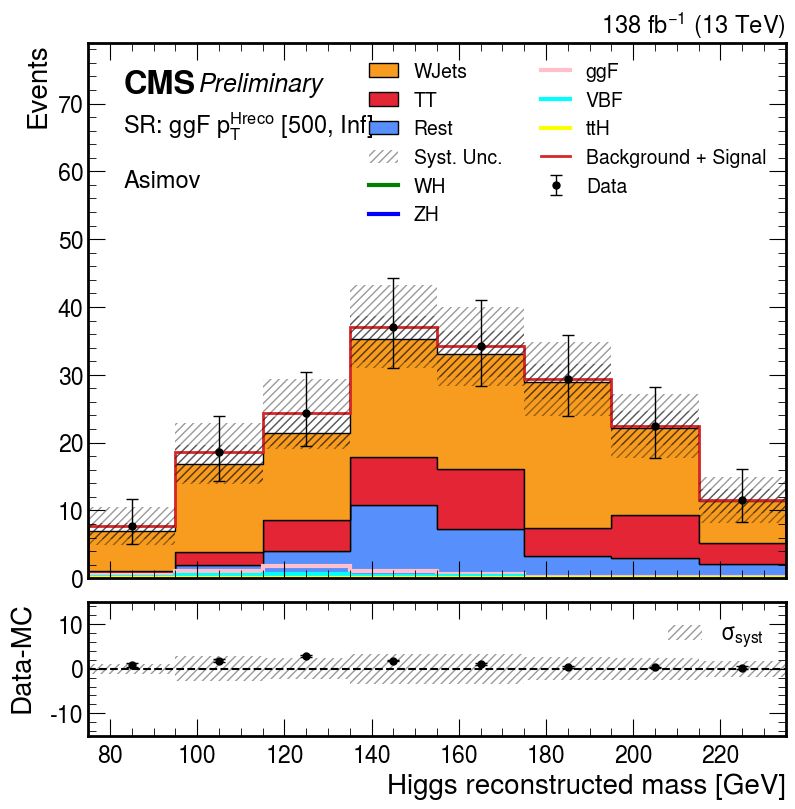

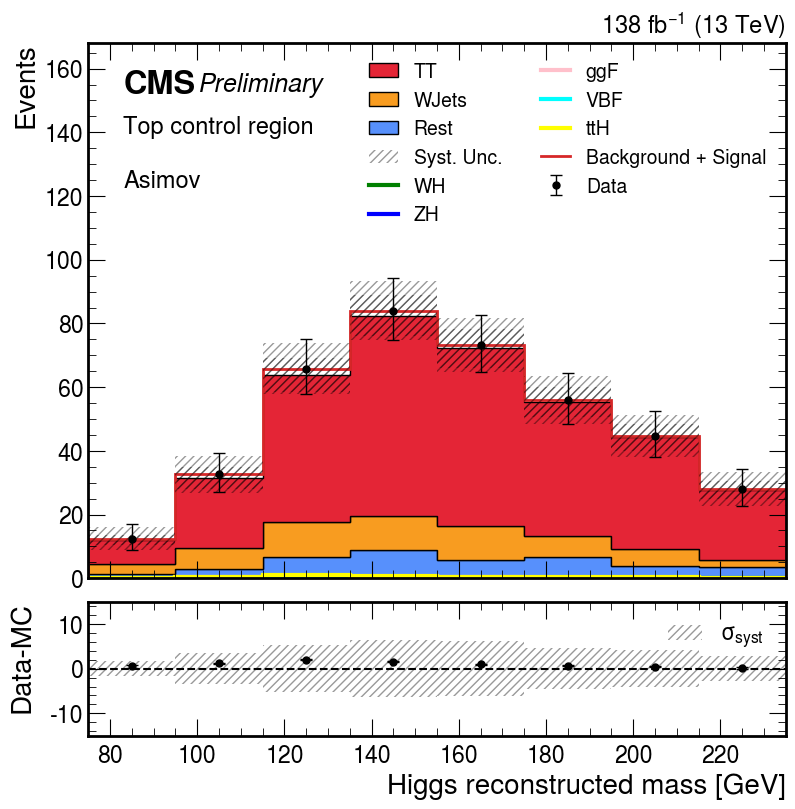

In [18]:
key = "shapes_fit_s"

for region in [
    "SR1",
    "SR2",
    "SR3",
    "SR4",
    "CR1",
#     "CR2",
]:
    hf, tot_err_mc, tot_err_data = build_hist_from_rootfile(f, key, region)

    plot_hists(
        hf, 
        years, 
        channels,
        mult=1,
        out_dir=f"{out_dir}/{key}",
        out_fname=region,
        ax_plot_sig=True,
        ax_plot_bkg=True,
        ax_plot_tot_sig=False,
        ax_plot_tot_bkg_sig=True,
        rax_plot_sig=False,
        rax_plot_bkg=True,
        rax_plot_tot_sig=False,               
#         remove_samples=["ttH", "WH", "ZH"],
        legend_title=region_dict[region],
        blind_region=False,
        label_on_plot="Asimov",        
        ######### error bars
        use_postfit_errors=True,
        postfit_errors_mc=tot_err_mc,
        postfit_errors_data=tot_err_data,
        ratio_plot="Data-MC",
    ) 

# Unblinding

## 0. Prefits

In [19]:
out_dir = "/Users/fmokhtar/Desktop/AN_2024/combine/v15/singlePOI/"
f = uproot.open(f"{out_dir}/fitDiagnosticsUnblinded_singlePOI.root")

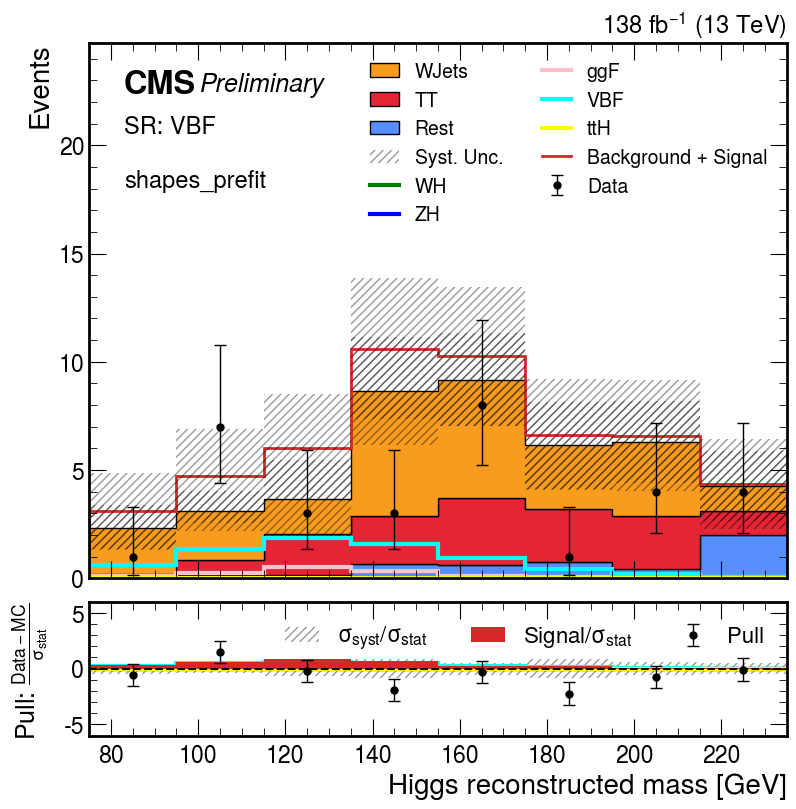

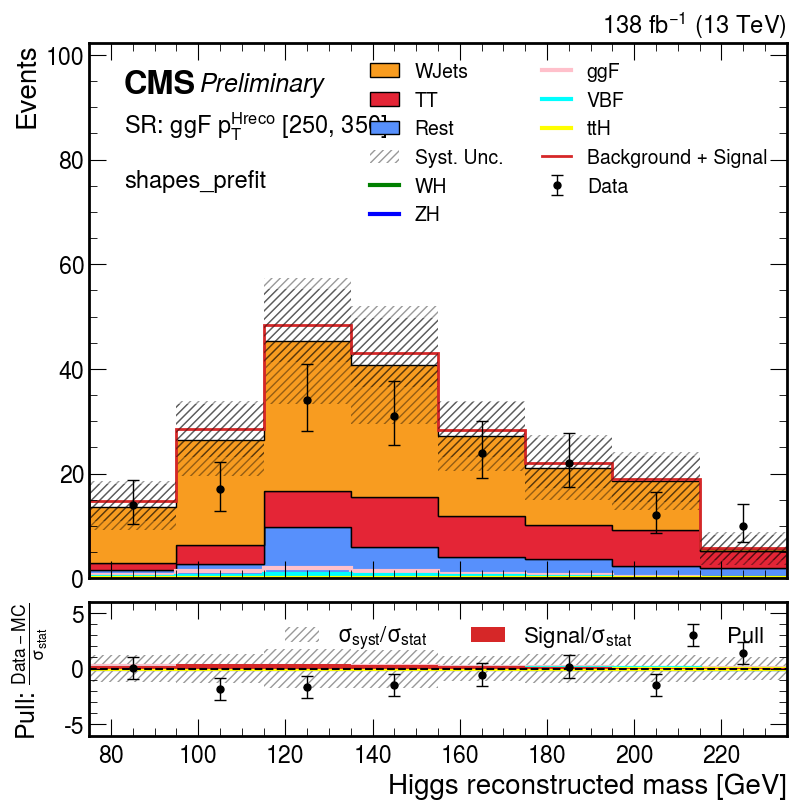

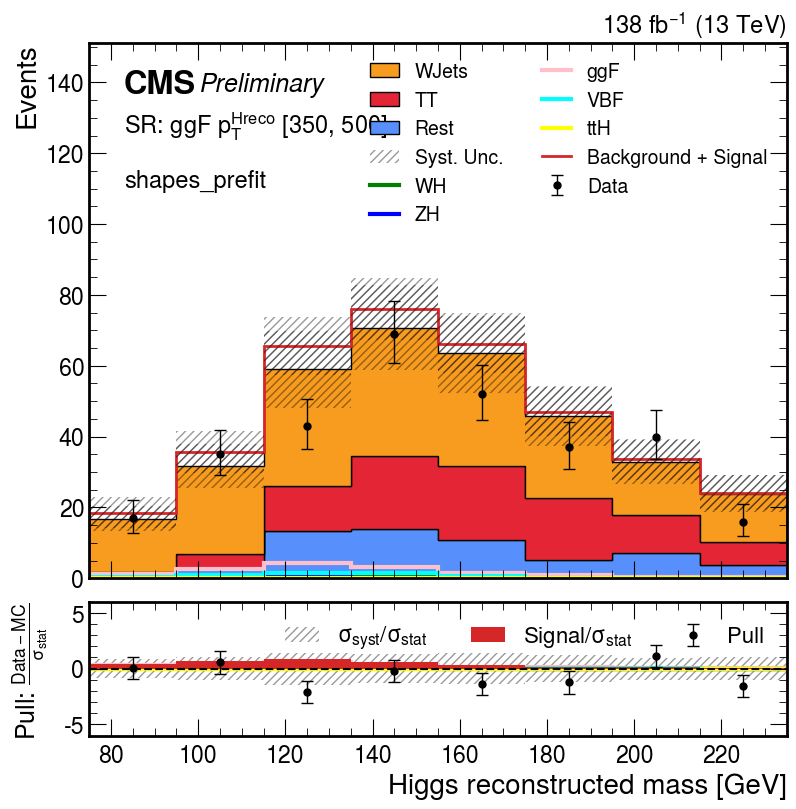

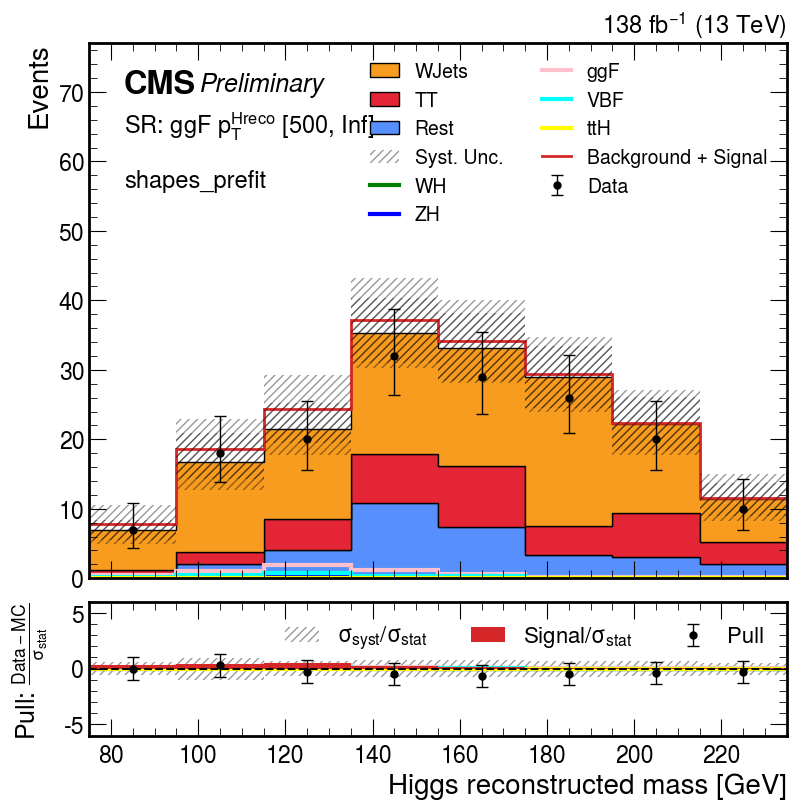

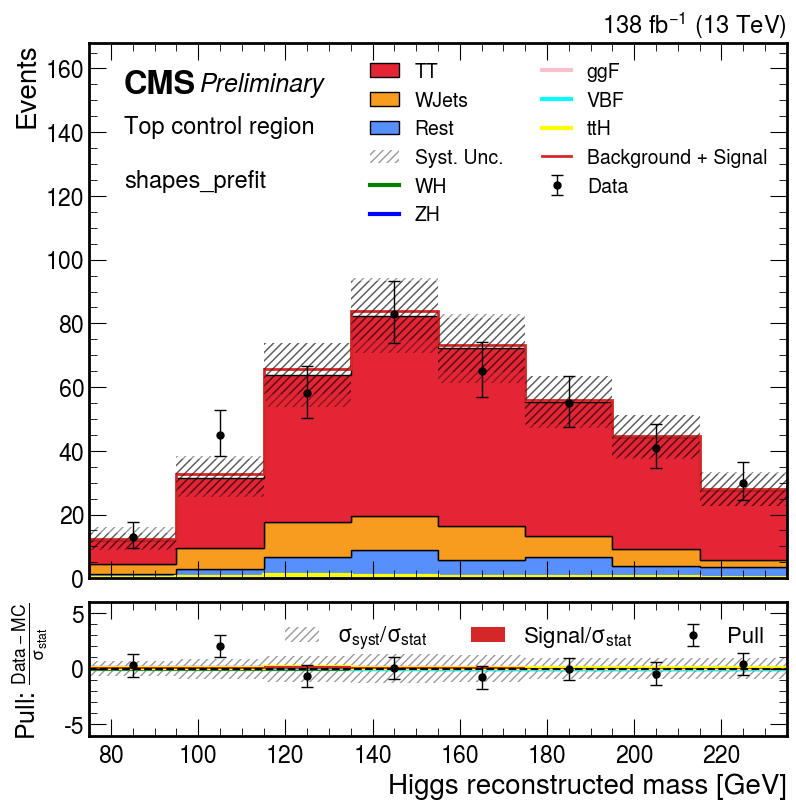

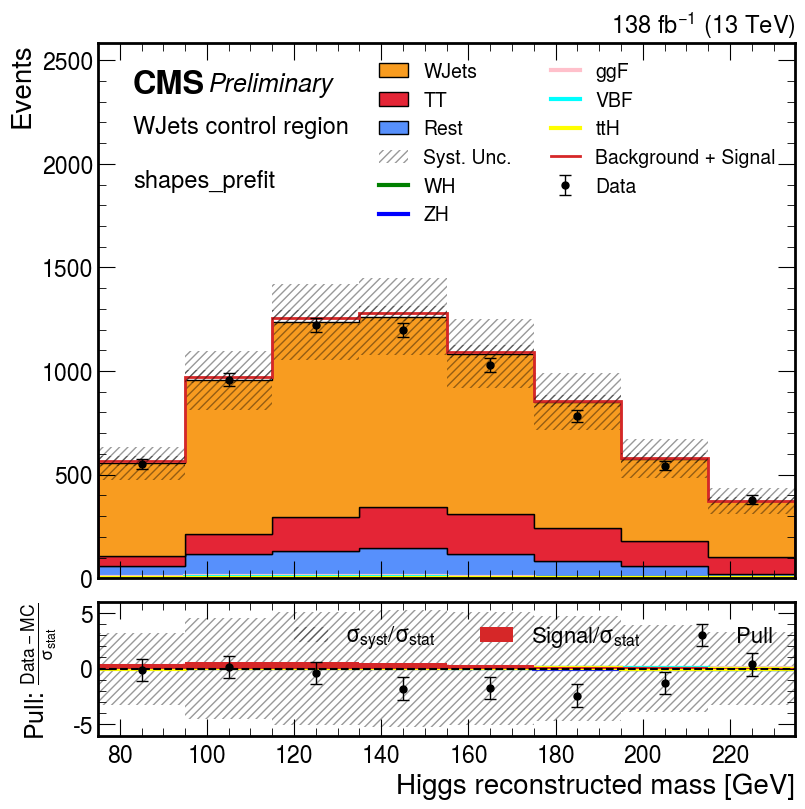

In [20]:
key = "shapes_prefit"

for region in [
    "SR1",
    "SR2",
    "SR3",
    "SR4",
    "CR1",
    "CR2",
]:
    hf, tot_err_mc, tot_err_data = build_hist_from_rootfile(f, key, region)

    plot_hists(
        hf, 
        years, 
        channels,
        mult=1,
        out_dir=f"{out_dir}/{key}",
        out_fname=region,
        ax_plot_sig=True,
        ax_plot_bkg=True,
        ax_plot_tot_sig=False,
        ax_plot_tot_bkg_sig=True,
        rax_plot_sig=True,
        rax_plot_bkg=True,
        rax_plot_tot_sig=True,
#         remove_samples=["ttH", "WH", "ZH"],
        legend_title=region_dict[region],
        blind_region=False,
        label_on_plot=key,        
        ######### error bars
        use_postfit_errors=True,
        postfit_errors_mc=tot_err_mc,
        postfit_errors_data=tot_err_data,
        ratio_plot="Pulls",
    ) 

## 1. Single POI fit

In [21]:
out_dir = "/Users/fmokhtar/Desktop/AN_2024/combine/v15/singlePOI/"
f = uproot.open(f"{out_dir}/fitDiagnosticsUnblinded_singlePOI.root")

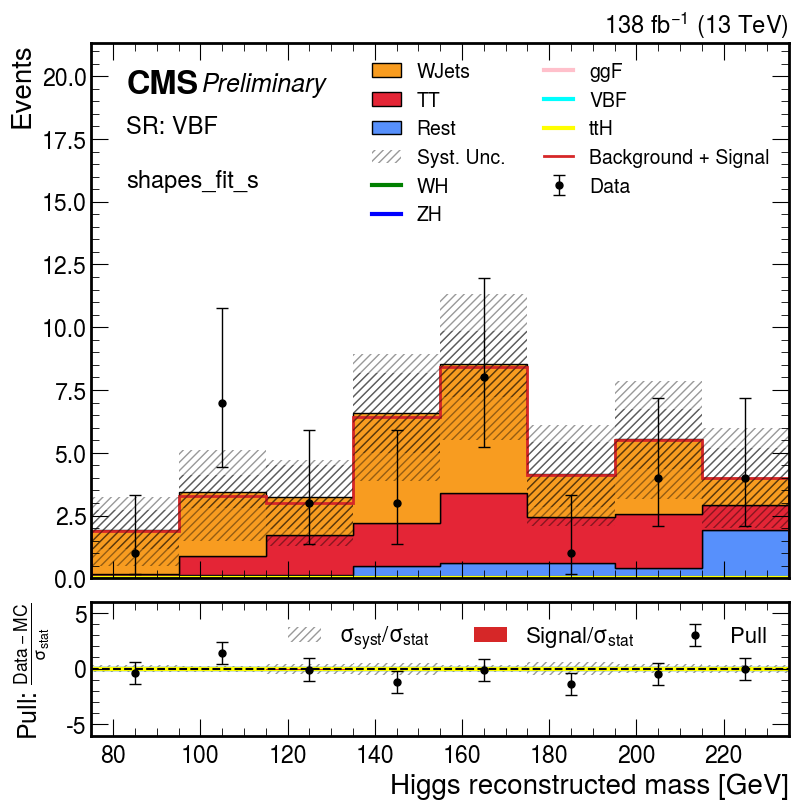

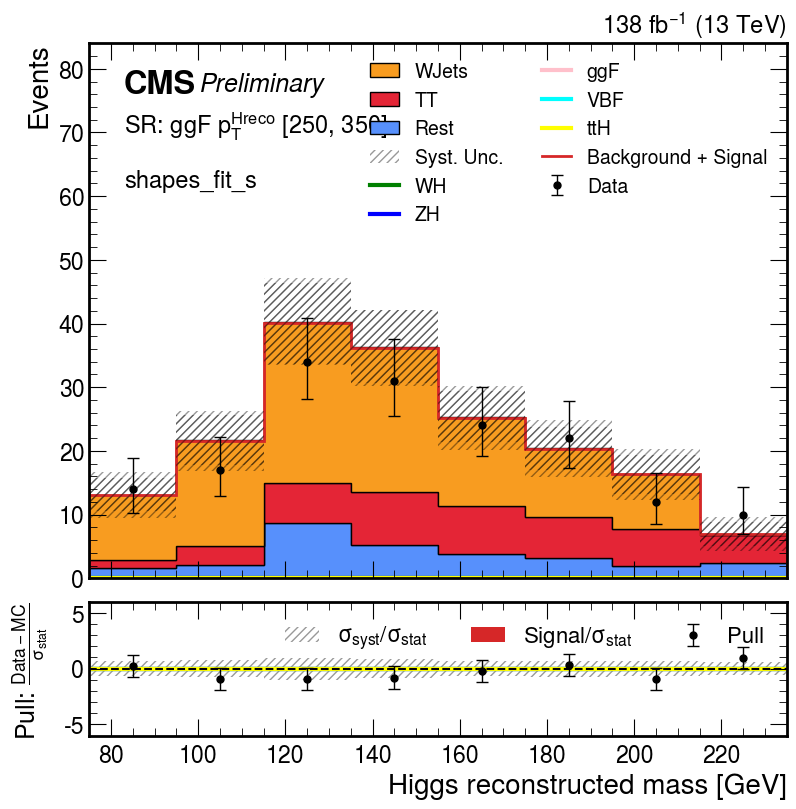

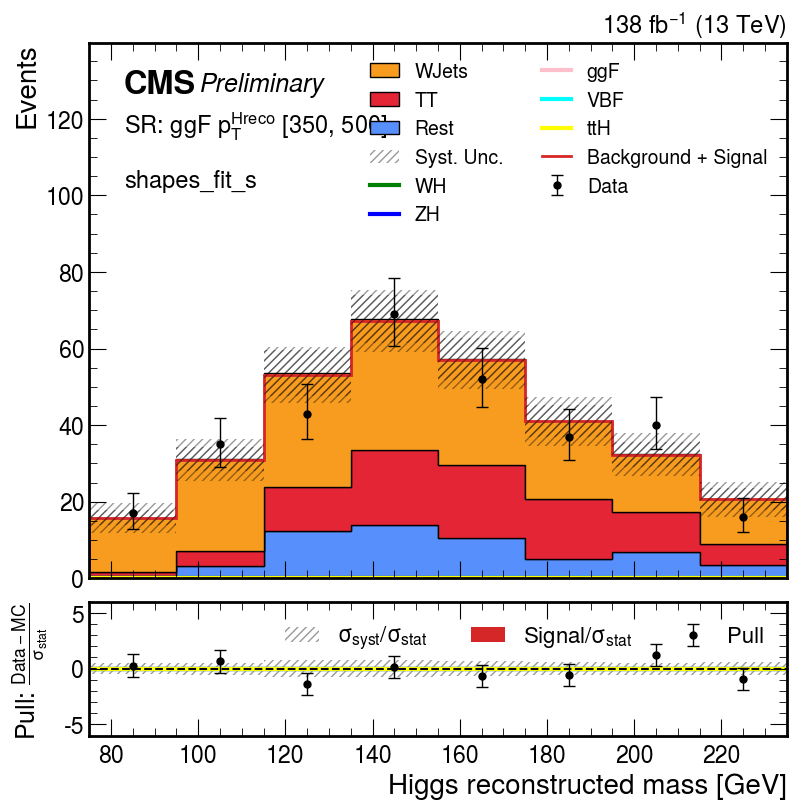

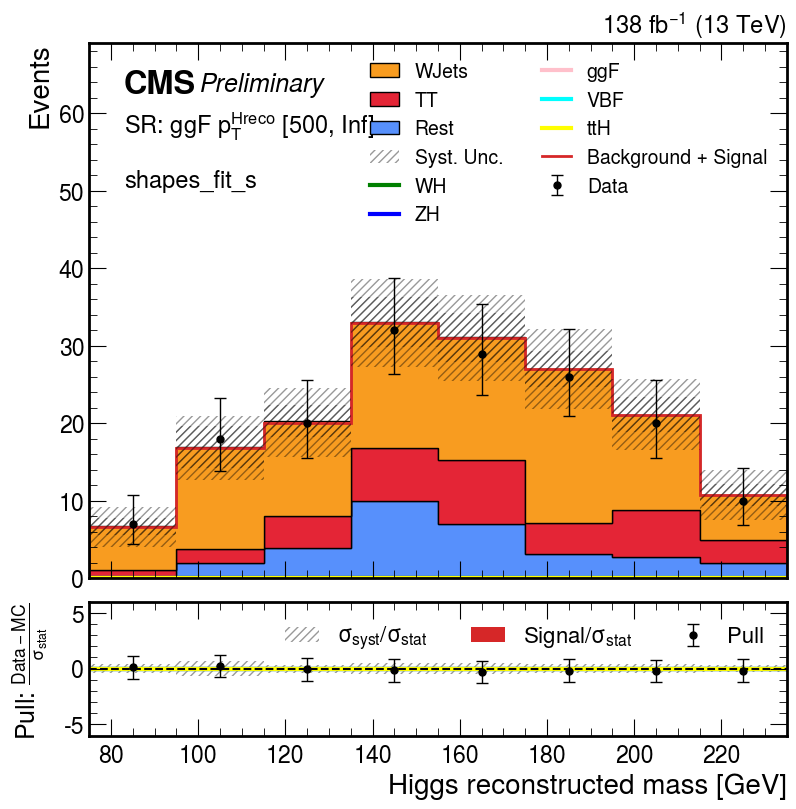

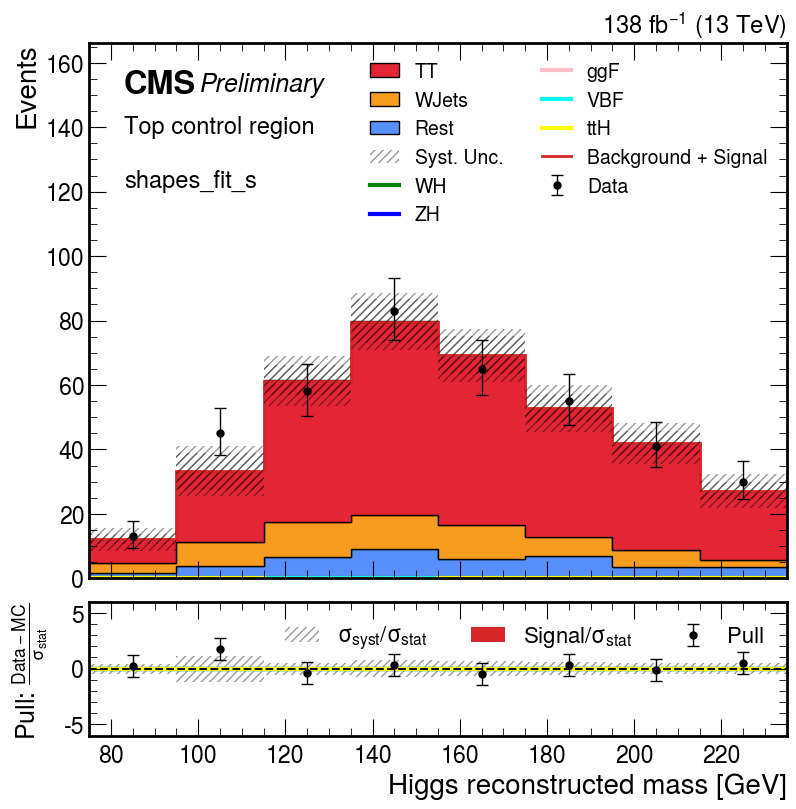

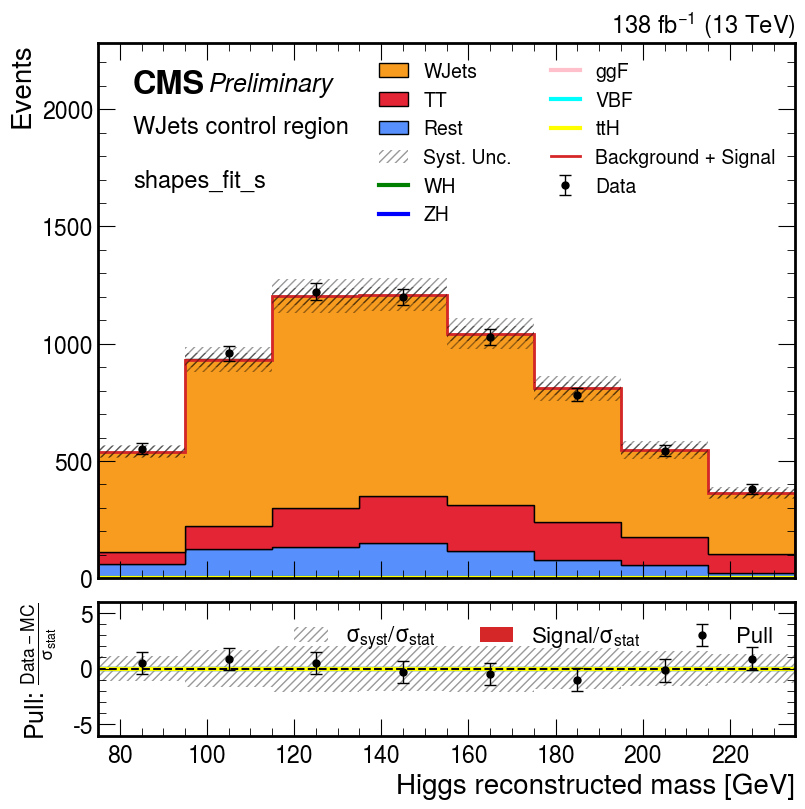

In [22]:
key = "shapes_fit_s"

if key == "shapes_fit_s":
    ax_plot_tot_bkg_sig = True
    ax_plot_sig = True
    rax_plot_tot_bkg_sig = True
    rax_plot_sig = True
    rax_plot_tot_sig = True
else:
    ax_plot_tot_bkg_sig = False
    ax_plot_sig = False
    rax_plot_tot_bkg_sig = False
    rax_plot_sig = False
    rax_plot_tot_sig = False
    
for region in [
    "SR1",
    "SR2",
    "SR3",
    "SR4",
    "CR1",
    "CR2",
#     "CR3",
#     "CR4",
]:
    hf, tot_err_mc, tot_err_data = build_hist_from_rootfile(f, key, region)

    plot_hists(
        hf, 
        years, 
        channels,
        mult=1,
        out_dir=f"{out_dir}/singlePOI_{key}",
        out_fname=region,
        ax_plot_sig=ax_plot_sig,
        ax_plot_bkg=True,
        ax_plot_tot_sig=False,
        ax_plot_tot_bkg_sig=ax_plot_tot_bkg_sig,
        rax_plot_sig=rax_plot_sig,
        rax_plot_bkg=True,
        rax_plot_tot_sig=rax_plot_tot_sig,
#         remove_samples=["ttH", "WH", "ZH"],
        legend_title=region_dict[region],
        blind_region=False,
        label_on_plot=key,        
        ######### error bars
        use_postfit_errors=True,
        postfit_errors_mc=tot_err_mc,
        postfit_errors_data=tot_err_data,
        ratio_plot="Pulls",
    ) 

## 2. Unfolding fit

In [23]:
out_dir = "/Users/fmokhtar/Desktop/AN_2024/combine/v15/unfolding/"
f = uproot.open(f"{out_dir}/fitDiagnosticsUnblinded_unfolding.root")

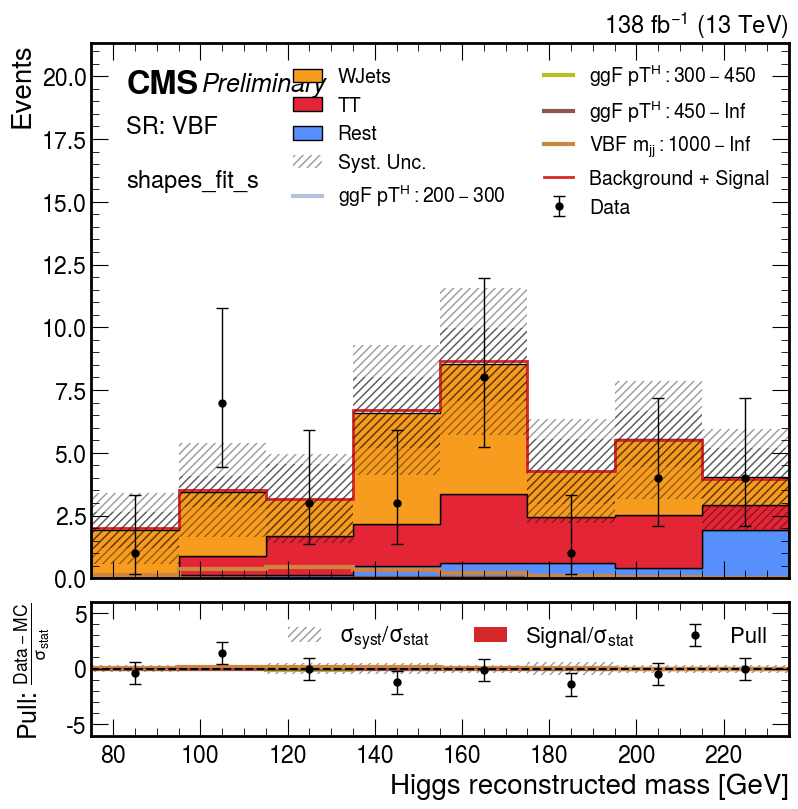

In [24]:
key = "shapes_fit_s"

if key == "shapes_fit_s":
    ax_plot_tot_bkg_sig = True
    ax_plot_sig = True
    rax_plot_tot_bkg_sig = True
    rax_plot_sig = True
    rax_plot_tot_sig = True
else:
    ax_plot_tot_bkg_sig = False
    ax_plot_sig = False
    rax_plot_tot_bkg_sig = False
    rax_plot_sig = False
    rax_plot_tot_sig = False
    
    
for region in [
    "SR1",
#     "SR2",
#     "SR3",
#     "SR4",
#     "CR1",
#     "CR2",
]:
    hf, tot_err_mc, tot_err_data = build_hist_from_rootfile(f, key, region)

    plot_hists(
        hf, 
        years, 
        channels,
        mult=1,
        out_dir=f"{out_dir}/unfolding_{key}",
        out_fname=region,
        ax_plot_sig=ax_plot_sig,
        ax_plot_bkg=True,
        ax_plot_tot_sig=False,
        ax_plot_tot_bkg_sig=ax_plot_tot_bkg_sig,
        rax_plot_sig=rax_plot_sig,
        rax_plot_bkg=True,
        rax_plot_tot_sig=rax_plot_tot_sig,
        remove_samples=["ttH", "WH", "ZH"],
        legend_title=region_dict[region],
        blind_region=False,
        label_on_plot=key,        
        ######### error bars
        use_postfit_errors=True,
        postfit_errors_mc=tot_err_mc,
        postfit_errors_data=tot_err_data,
        ratio_plot="Pulls",
    ) 